Most of the classical time series forecasting models assume that residuals have a constant volatility or variance. Many econometric series, especially, financial market data often exhibit volatility clustering, where time series show periods of high volatility and periods of low volatility. In stock market data, when returns are close to long term mean of returns, volatility is low compared to the periods when returns are away from long term mean. In fact, with economic and financial data, time dependent volatility is more common than constant volatility. We have discussed here how ARCH or GARCH models help forecasting of such volatility in financial engineering.

Here we will show you the applications of ARCH and GARCH models in Python with stock market data.

We will use BSE SENSEX data from 31/DEC/2010 to 31/DEC/2018. You can download the dataset from the following link: https://spotleai.sgp1.digitaloceanspaces.com/course/data/bse_sensex_7y.csv

Let’s perform time series modelling on logarithmic returns of BSE SENSEX data.

The process is as follows:

    1 Find best combinations of (p, q) for ARIMA(p, 0, q) models.
    2 Apply the GARCH model to residuals of the best ARIMA model with lowest AIC (Akaike’s Information Criterion).
    3 Examine the model residuals and squared residuals for autocorrelation
    
ARCH model is a special case of GARCH model when p = 0 that is ARCH(q) = GARCH(0,q).

First, let's load the data. The dataset has a total of 1963 trading days information on opening price (open), highest price (high), lowest price (low), closing price (close) , adjusted close (adjusted close) and total volume traded (volume) of BSE SENSEX in 7 years.

In [1]:
from pandas import read_csv
from matplotlib import pyplot
import numpy as np

filename = 'https://spotleai.sgp1.digitaloceanspaces.com/course/data/bse_sensex_7y.csv'
data = read_csv(filename, index_col=0, parse_dates=True, squeeze=True)
print(data.shape)
print(data.columns)

HTTPError: HTTP Error 404: Not Found

Our main interest is to compute logarithmic returns of BSE SENSEX.

In [2]:
data = data['Adj Close']
log_returns = np.log(data/data.shift())
log_returns = log_returns.dropna()
log_returns.head()

Date
2011-03-01    0.002530
2011-04-01   -0.003036
2011-05-01   -0.009687
2011-06-01   -0.005748
2011-07-01   -0.024724
Name: Adj Close, dtype: float64

Usually return series of stocks are stationary. Let's check the fact with Augmented Dickey-Fuller (ADF) test.

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(log_returns)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -40.898207
p-value: 0.000000


Since the p-value < 0.05, the series is stationary.

In [4]:
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")

res = arma_order_select_ic(log_returns, max_ar = 6, max_ma = 3, ic=["aic", "bic"])
print(res.aic_min_order)
print(res.bic_min_order)

(0, 1)
(0, 1)


The best model is ARIMA(0, 0, 1). Let's fit ARIMA(0, 0, 1) model and then plot the residuals to decide if they possess evidence of conditional heteroskedastic behaviour.

In [5]:
from statsmodels.tsa.arima.model import ARIMA

arima_order = (res.aic_min_order[0], 0, res.aic_min_order[1])

model = ARIMA(log_returns, order=arima_order).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1962
Model:                 ARIMA(0, 0, 1)   Log Likelihood                6336.875
Date:                Thu, 24 Mar 2022   AIC                         -12667.751
Time:                        15:13:44   BIC                         -12651.006
Sample:                             0   HQIC                        -12661.596
                               - 1962                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.216      0.224      -0.000       0.001
ma.L1          0.0794      0.020      3.874      0.000       0.039       0.120
sigma2      9.156e-05   2.11e-06     43.388      0.0

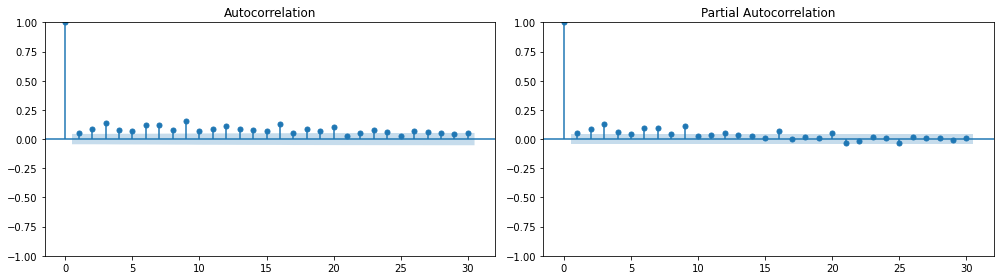

In [6]:
import statsmodels.tsa.api as smt
def correlation_plot(y, lags = 30):
  fig = pyplot.figure(figsize=(14, 4))
  layout = (1, 2)
  acf_ax = pyplot.subplot2grid(layout, (0, 0))
  pacf_ax = pyplot.subplot2grid(layout, (0, 1))

  smt.graphics.plot_acf(y**2, lags=lags, ax=acf_ax, alpha=0.05)
  smt.graphics.plot_pacf(y**2, lags=lags, ax=pacf_ax, alpha=0.05)
  pyplot.tight_layout()

correlation_plot(model.resid, 30)

ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) plots show strong evidence of serial correlation in the residual series. Let's fit GARCH model.

In [7]:
from arch import arch_model

residuals = model.resid

am = arch_model(model.resid, o=arima_order[1], q=arima_order[2], dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1349.56
Distribution:      Standardized Student's t   AIC:                           2709.11
Method:                  Maximum Likelihood   BIC:                           2737.02
                                              No. Observations:                 1962
Date:                      Thu, Mar 24 2022   Df Residuals:                     1961
Time:                              15:13:46   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

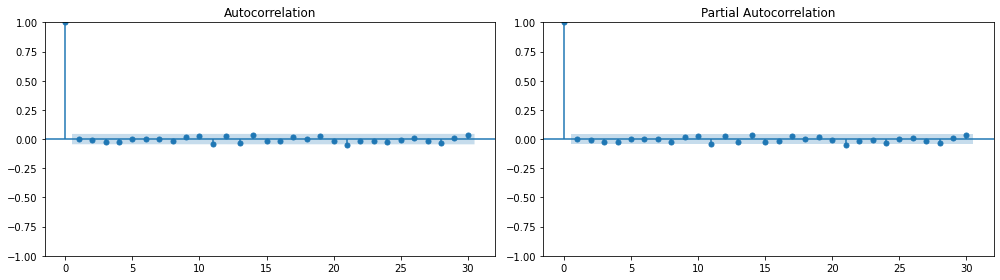

In [8]:
correlation_plot(res.resid, 30)